In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

RANDOM_STATE = 42
DEBUG = True
DEMONSTRATION = True

np.random.seed(RANDOM_STATE)

In [2]:
X_train = pd.read_csv('X_train.csv', header=None)
X_train.columns = [f'f_{i}' for i in range(X_train.shape[1])]

y_train = pd.read_csv('y_train.csv', header=None).values.ravel()

X_test = pd.read_csv('X_test.csv', header=None)
X_test.columns = [f'f_{i}' for i in range(X_test.shape[1])]

In [3]:
X_train.drop(columns=[f'f_{i}' for i in range(8)], inplace=True)
X_test.drop(columns=[f'f_{i}' for i in range(8)], inplace=True)

X_train = pd.get_dummies(X_train, columns=['f_13'], prefix='f_13')
X_test = pd.get_dummies(X_test, columns=['f_13'], prefix='f_13')

In [4]:
mask_0 = X_train['f_12'] == 0
mask_1 = X_train['f_12'] == 1

X_train.drop(columns='f_12', inplace=True)

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'iterations': randint(300, 1500),
    'learning_rate': uniform(0.01, 0.3),
    'depth': randint(4, 12),
    'l2_leaf_reg': uniform(1, 15),
    'bagging_temperature': uniform(0, 1),
    'border_count': randint(32, 255),
    'random_strength': uniform(1, 10),
    'leaf_estimation_iterations': randint(1, 10)
}

In [6]:
from catboost import CatBoostRegressor

def run_random_search(X, y, param_dist, random_state, n_iter=100):
    search = RandomizedSearchCV(
        CatBoostRegressor(verbose=0, random_state=random_state, early_stopping_rounds=20),
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=random_state
    )
    search.fit(X, y)
    
    return search.best_estimator_

In [7]:
if DEMONSTRATION:
    model_0 = joblib.load('model_0.pkl')
    model_1 = joblib.load('model_1.pkl')
else:
    model_0 = run_random_search(X_train[mask_0], y_train[mask_0], param_dist, RANDOM_STATE)
    model_1 = run_random_search(X_train[mask_1], y_train[mask_1], param_dist, RANDOM_STATE)
    
    model_0.fit(X_train[mask_0], y_train[mask_0])
    model_1.fit(X_train[mask_1], y_train[mask_1])
    
    joblib.dump(model_0, f"model_0.pkl")
    joblib.dump(model_1, f"model_1.pkl")

In [8]:
from sklearn.model_selection import cross_val_score

if DEBUG:
    scores_0 = -cross_val_score(model_0, X_train[mask_0], y_train[mask_0], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    scores_1 = -cross_val_score(model_1, X_train[mask_1], y_train[mask_1], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    print(f"MSE по фолдам: {scores_0}")
    print(f"Отклонение: {np.std(scores_0)}")
    print(f"Средний MSE: {np.mean(scores_0)}")

    print()

    print(f"MSE по фолдам: {scores_1}")
    print(f"Отклонение: {np.std(scores_1)}")
    print(f"Средний MSE: {np.mean(scores_1)}")

    print()

    len_0 = len(X_train[mask_0])
    len_1 = len(X_train[mask_1])

    print(f"Взвешенный MSE: {(np.mean(scores_0) * len_0 + np.mean(scores_1) * len_1) / (len_0 + len_1)}")

MSE по фолдам: [0.02704528 0.02255584 0.02293553 0.02593817 0.02404676]
Отклонение: 0.0017308623008721854
Средний MSE: 0.024504317149676484

MSE по фолдам: [0.02325347 0.02279134 0.02337219 0.02482727 0.02302923]
Отклонение: 0.0007144677758538352
Средний MSE: 0.02345469800651987

Взвешенный MSE: 0.02398003238766976


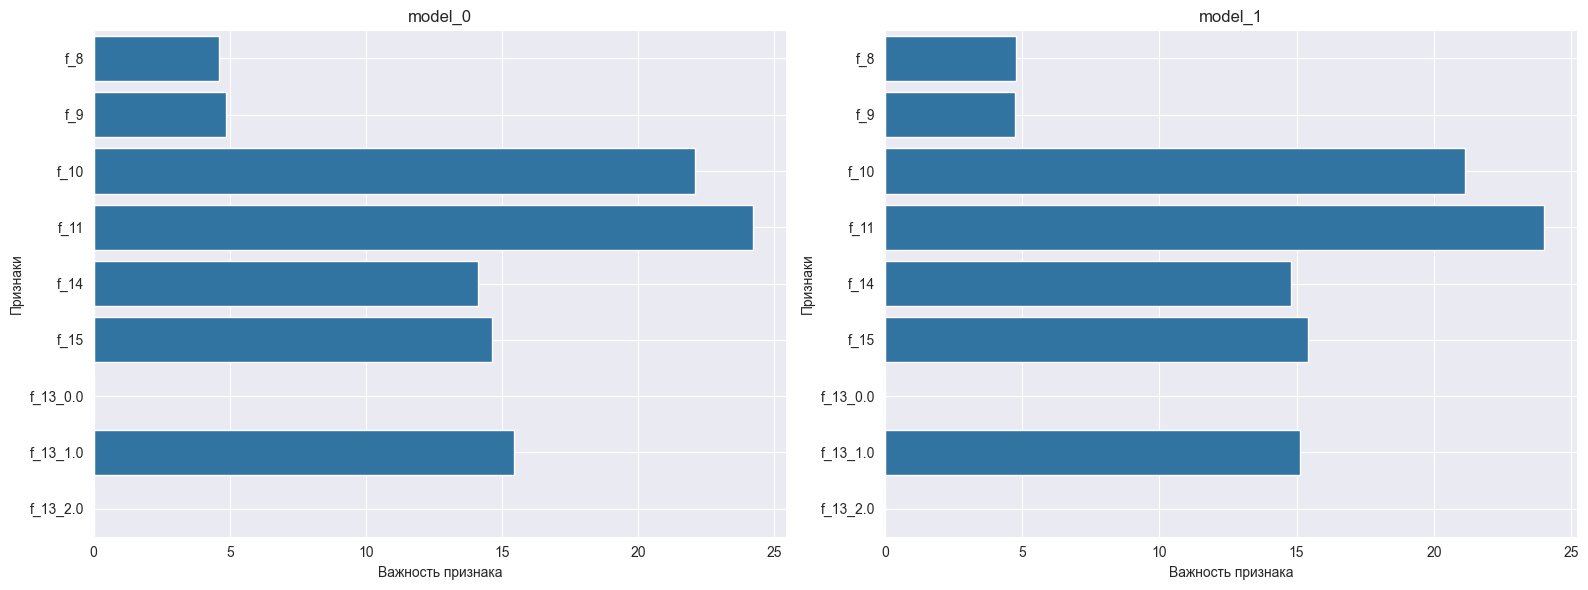

In [9]:
features = list(X_train.columns)

coefs_0 = model_0.feature_importances_
coefs_1 = model_1.feature_importances_

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=coefs_0, y=features, orient='h')
plt.title("model_0")
plt.xlabel("Важность признака")
plt.ylabel("Признаки")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.barplot(x=coefs_1, y=features, orient='h')
plt.title("model_1")
plt.xlabel("Важность признака")
plt.ylabel("Признаки")
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
test_mask_0 = X_test['f_12'] == 0
test_mask_1 = X_test['f_12'] == 1

X_test.drop(columns='f_12', inplace=True)

In [11]:
y_pred_0 = model_0.predict(X_test[test_mask_0])
y_pred_1 = model_1.predict(X_test[test_mask_1])

y_pred = np.empty_like(np.zeros(len(X_test)), dtype=float)
y_pred[test_mask_0] = y_pred_0
y_pred[test_mask_1] = y_pred_1

In [12]:
submission = pd.DataFrame(y_pred, columns=["y"])
submission["ID"] = list(range(len(y_pred)))
submission.to_csv("submission.csv", sep=",", index=False)